In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import random
import math
import sys

# ==============================================================================
# PHẦN 1: NẠP DỮ LIỆU & XỬ LÝ LỖI (DATA LOADING)
# ==============================================================================

# CẤU HÌNH ĐƯỜNG DẪN FILE CỦA BẠN Ở ĐÂY
# Lưu ý: Thêm chữ r phía trước để tránh lỗi đường dẫn Windows
FILE_PATH = r'D:\GIS_Project\data\6_DSCanhKQ2_CanTho_XoaCon3Cot_XoaDongTrung.txt'

print(f"--- 1. ĐANG ĐỌC FILE DỮ LIỆU ---")
try:
    # Đọc file (giả định cách nhau bằng tab hoặc khoảng trắng)
    try:
        df = pd.read_csv(FILE_PATH, sep='\t')
    except:
        df = pd.read_csv(FILE_PATH, delim_whitespace=True)

    # --- TỰ ĐỘNG SỬA LỖI TÊN CỘT ---
    # Xóa khoảng trắng thừa trong tên cột (nếu có)
    df.columns = df.columns.str.strip()
    
    # Sửa lỗi chính tả 'IdStar' -> 'IdStart'
    if 'IdStar' in df.columns:
        print("-> Phát hiện cột 'IdStar', tự động đổi thành 'IdStart'.")
        df.rename(columns={'IdStar': 'IdStart'}, inplace=True)
    
    print(f"-> Đã đọc {len(df)} dòng.")
    print("-> Cột hiện tại:", df.columns.tolist())

    # Tạo đồ thị NetworkX
    G = nx.from_pandas_edgelist(df, source='IdStart', target='IdEnd', edge_attr='Length')

    # Chuẩn hóa trọng số sang 'weight'
    for u, v in G.edges():
        G[u][v]['weight'] = G[u][v]['Length']

    # Tạo danh sách điểm dữ liệu (Lấy tất cả các nút trong file)
    data_nodes = list(G.nodes())
    print(f"-> Đồ thị có {G.number_of_nodes()} đỉnh và {G.number_of_edges()} cạnh.")

except Exception as e:
    print(f"\n[LỖI NGHIÊM TRỌNG]: {e}")
    print("Vui lòng kiểm tra lại đường dẫn file hoặc tên cột.")
    sys.exit() # Dừng chương trình nếu lỗi file

--- 1. ĐANG ĐỌC FILE DỮ LIỆU ---
-> Đã đọc 3093 dòng.
-> Cột hiện tại: ['IdStart', 'IdEnd', 'Length']
-> Đồ thị có 2434 đỉnh và 2925 cạnh.


In [2]:
# ==============================================================================
# PHẦN 2: THUẬT TOÁN NS-DBSCAN CẢI TIẾN (OPTIMIZED ENGINE)
# ==============================================================================

# 2.1. Tìm hàng xóm trên đồ thị cắt tỉa (Pruned Graph)
def get_network_neighbors_optimized(G_pruned, start_node, eps, data_set_lookup):
    distances = {start_node: 0}
    queue = [(0, start_node)]
    n_eps = [] 

    while queue:
        current_dist, u = heapq.heappop(queue)
        if current_dist > eps: continue # Dừng sớm

        if u in data_set_lookup: n_eps.append(u)
        
        # Chỉ duyệt trên G_pruned (ít cạnh hơn)
        for v in G_pruned.neighbors(u):
            weight = G_pruned[u][v]['weight']
            new_dist = current_dist + weight
            if new_dist <= eps:
                if new_dist < distances.get(v, float('inf')):
                    distances[v] = new_dist
                    heapq.heappush(queue, (new_dist, v))
    return n_eps

# 2.2. Tính mật độ & Lọc Heuristic
def algorithm_2_density_ordering_optimized(G_pruned, data_points, eps):
    data_set_lookup = set(data_points)
    n = len(data_points)
    # Ngưỡng lọc tự động ln(n)
    density_threshold = math.log(n) if n > 0 else 0
    print(f"   > Ngưỡng lọc Heuristic (ln({n})): {density_threshold:.2f}")
    
    ordered_list = []
    neighbors_cache = {} 
    
    for p in data_points:
        nbrs = get_network_neighbors_optimized(G_pruned, p, eps, data_set_lookup)
        density = len(nbrs)
        # Chỉ giữ lại điểm "xịn"
        if density >= density_threshold:
            ordered_list.append((density, p))
            neighbors_cache[p] = nbrs
            
    ordered_list.sort(key=lambda x: x[0], reverse=True)
    density_ordering_table = [item[1] for item in ordered_list]
    return density_ordering_table, neighbors_cache

# 2.3. Gom cụm (Bỏ qua check nhiễu)
def algorithm_3_forming_clusters_optimized(density_ordering_table, neighbors_cache, min_pts):
    labels = {} 
    cluster_id = 0
    
    for p in density_ordering_table:
        if p in labels: continue
        p_neighbors = neighbors_cache[p]
        
        if len(p_neighbors) >= min_pts:
            cluster_id += 1
            labels[p] = cluster_id
            seeds = list(p_neighbors)
            i = 0
            while i < len(seeds):
                q = seeds[i]
                if q not in labels: # Chưa có nhãn -> Gán luôn
                    labels[q] = cluster_id
                    if q in neighbors_cache:
                        q_neighbors = neighbors_cache[q]
                        if len(q_neighbors) >= min_pts:
                            seeds.extend(q_neighbors)
                i += 1
    return labels

# 2.4. Hàm chạy chính
def run_ns_dbscand_optimized(G, data_points, eps, min_pts):
    print("\n--- BẮT ĐẦU NS-DBSCAND (BẢN CẢI TIẾN) ---")
    
    # Bước 0: Cắt tỉa đồ thị (Pruning)
    print("Step 0: Đang cắt tỉa các cạnh quá dài...")
    valid_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] <= eps]
    G_pruned = nx.Graph()
    G_pruned.add_nodes_from(G.nodes())
    G_pruned.add_edges_from(valid_edges)
    
    print("Step 1: Tính mật độ (Có lọc Heuristic)...")
    table, cache = algorithm_2_density_ordering_optimized(G_pruned, data_points, eps)
    print(f"   -> Số điểm đạt chuẩn để xét: {len(table)}/{len(data_points)}")
    
    print("Step 2: Gom cụm (Tối ưu vòng lặp)...")
    labels = algorithm_3_forming_clusters_optimized(table, cache, min_pts)
    return labels

In [4]:
# ==============================================================================
# PHẦN 3: HÀM VẼ ZOOM (CHO DỮ LIỆU LỚN)
# ==============================================================================
def visualize_directed_flow_zoom(G, center_node, eps, zoom_radius=3):
    """
    Vẽ vùng lân cận của 1 điểm với mũi tên chỉ hướng đi.
    zoom_radius: Số lớp hàng xóm để cắt đồ thị con (giúp hình không bị rối)
    """
    print(f"\n--- ĐANG VẼ MÔ PHỎNG TỪ TÂM: {center_node} ---")
    
    # 1. Cắt đồ thị con (Ego Graph)
    try:
        # Lấy các node trong phạm vi zoom_radius bước nhảy
        sub_nodes = nx.single_source_shortest_path_length(G, center_node, cutoff=zoom_radius).keys()
        G_sub = G.subgraph(sub_nodes).copy()
    except:
        print(f"Lỗi: Không tìm thấy node {center_node} trong đồ thị.")
        return

    # 2. Tạo layout riêng cho đồ thị con này (để hình đẹp nhất)
    pos_sub = nx.spring_layout(G_sub, seed=42, k=2.0) # k lớn để giãn hình
    
    # 3. Tìm luồng đi (Flow)
    distances = {center_node: 0}
    queue = [(0, center_node)]
    path_edges = [] 
    reachable_nodes = []
    
    while queue:
        curr_dist, u = heapq.heappop(queue)
        if curr_dist > eps: continue
        
        if u != center_node: reachable_nodes.append(u)
            
        if u in G_sub: # Chỉ vẽ đường đi nằm trong vùng zoom
            for v in G_sub.neighbors(u):
                weight = G_sub[u][v]['weight']
                new_dist = curr_dist + weight
                
                if new_dist <= eps:
                    if new_dist < distances.get(v, float('inf')):
                        distances[v] = new_dist
                        heapq.heappush(queue, (new_dist, v))
                        path_edges.append((u, v))

    # 4. Vẽ Hình
    plt.figure(figsize=(12, 10))
    
    # Nền mờ
    nx.draw_networkx_edges(G_sub, pos_sub, edge_color='#EEEEEE', width=1, arrows=False)
    nx.draw_networkx_nodes(G_sub, pos_sub, node_color='#F0F0F0', node_size=100)
    
    # Nhãn trọng số mờ
    all_weights = nx.get_edge_attributes(G_sub, 'weight')
    all_weights = {k: f"{v:.1f}" for k, v in all_weights.items()}
    nx.draw_networkx_edge_labels(G_sub, pos_sub, edge_labels=all_weights, font_color='#CCCCCC', font_size=7)

    # Mũi tên Đỏ (Luồng đi)
    nx.draw_networkx_edges(G_sub, pos_sub, edgelist=path_edges, 
                           edge_color='red', width=2, 
                           arrows=True, arrowstyle='-|>', arrowsize=15)
    
    # Điểm Hàng xóm (Xanh) và Tâm (Vàng)
    if reachable_nodes:
        valid_reachable = [n for n in reachable_nodes if n in G_sub] # Chỉ vẽ điểm trong vùng zoom
        nx.draw_networkx_nodes(G_sub, pos_sub, nodelist=valid_reachable, node_color='#90EE90', node_size=400, label='Hàng xóm')
    
    nx.draw_networkx_nodes(G_sub, pos_sub, nodelist=[center_node], node_color='yellow', edgecolors='red', linewidths=2, node_size=600, label='Tâm')

    # Tên điểm
    nx.draw_networkx_labels(G_sub, pos_sub, font_size=9, font_weight='bold')
    
    plt.title(f"MÔ PHỎNG LUỒNG ĐI (ZOOM)\nTâm: {center_node} | Eps: {eps} | Bán kính Zoom: {zoom_radius} bước", fontsize=14)
    plt.legend()
    plt.axis('off')
    plt.show()


--- BẮT ĐẦU NS-DBSCAND (BẢN CẢI TIẾN) ---
Step 0: Đang cắt tỉa các cạnh quá dài...
Step 1: Tính mật độ (Có lọc Heuristic)...
   > Ngưỡng lọc Heuristic (ln(2434)): 7.80
   -> Số điểm đạt chuẩn để xét: 1875/2434
Step 2: Gom cụm (Tối ưu vòng lặp)...

=== KẾT QUẢ PHÂN CỤM ===
Tổng số điểm: 2434
Số điểm thuộc cụm: 1574
Số điểm nhiễu: 860
Số lượng cụm tìm thấy: 12

--- ĐANG VẼ MÔ PHỎNG TỪ TÂM: 1649 ---


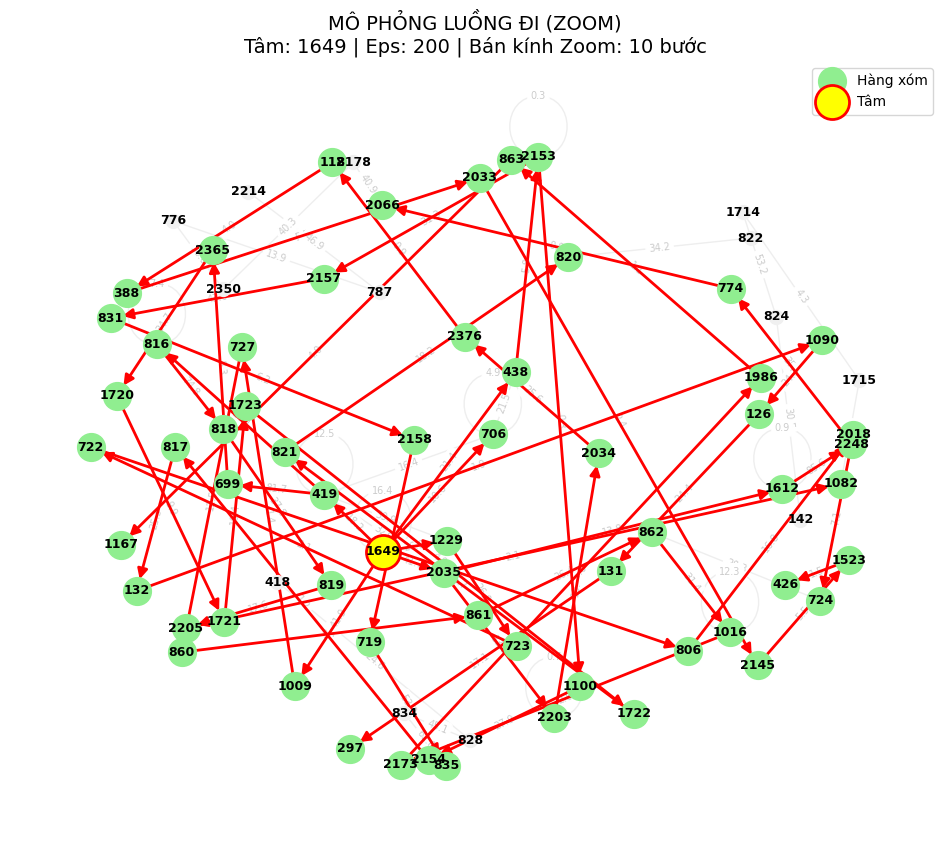

In [8]:
# ==============================================================================
# PHẦN 4: THỰC THI (MAIN)
# ==============================================================================

# --- CẤU HÌNH THAM SỐ ---
# Dựa trên dữ liệu Cần Thơ, khoảng cách có thể là 50m - 200m.
EPS_REAL = 200   # Tìm trong bán kính 150 mét
MIN_PTS_REAL = 20   # Cụm cần ít nhất 3 điểm

# 1. Chạy thuật toán phân cụm
labels = run_ns_dbscand_optimized(G, data_nodes, EPS_REAL, MIN_PTS_REAL)

# 2. In kết quả
n_clustered = len(labels)
n_noise = len(data_nodes) - n_clustered
print(f"\n=== KẾT QUẢ PHÂN CỤM ===")
print(f"Tổng số điểm: {len(data_nodes)}")
print(f"Số điểm thuộc cụm: {n_clustered}")
print(f"Số điểm nhiễu: {n_noise}")
print(f"Số lượng cụm tìm thấy: {len(set(labels.values()))}")

# 3. Vẽ mô phỏng luồng đi cho 1 điểm bất kỳ để báo cáo
# Lấy ngẫu nhiên 1 điểm đã được phân vào cụm để vẽ cho đẹp (tránh lấy điểm nhiễu)
if len(labels) > 0:
    demo_center = list(labels.keys())[0] # Lấy điểm đầu tiên tìm được
    visualize_directed_flow_zoom(G, center_node=demo_center, eps=EPS_REAL, zoom_radius=10)
else:
    print("Không tìm thấy cụm nào để vẽ mô phỏng.")